In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [4]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# csv파일 열기
filname = "./data/fer2013.csv"
expression_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names = ['emotion', 'pixels', 'usage']

dataset = pd.read_csv(filname, names=names, na_filter=False)
print(dataset.head(10))

   emotion                                             pixels     usage
0  emotion                                             pixels     Usage
1        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
2        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
3        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
4        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
5        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
6        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
7        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training
8        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...  Training
9        3  85 84 90 121 101 102 133 153 153 169 177 189 1...  Training


In [7]:
def getData(filname):
    # 이미지는 48x48
    # 이미지의 수는 35887
    X = []
    Y = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    
    # 정규화
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [8]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [9]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [10]:
# train과 test 셋 만들기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)


In [11]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [20]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=keras.optimizers.Adam())

    return model

model = my_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 128)      

In [22]:
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.optimizers import TFOptimizer

path_model = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(20, 64) # save model at this location after each epoch
checkpoint = ModelCheckpoint(path_model,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )
keras.backend.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            )


Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 252s 8ms/step - loss: 1.7590 - accuracy: 0.3049 - val_loss: 1.7397 - val_accuracy: 0.3196
Epoch 2/20
32298/32298 [==============================] - 246s 8ms/step - loss: 1.4997 - accuracy: 0.4217 - val_loss: 1.4930 - val_accuracy: 0.4230
Epoch 3/20
32298/32298 [==============================] - 242s 8ms/step - loss: 1.2834 - accuracy: 0.5145 - val_loss: 1.4496 - val_accuracy: 0.4472
Epoch 4/20
32298/32298 [==============================] - 248s 8ms/step - loss: 1.1156 - accuracy: 0.5812 - val_loss: 1.2144 - val_accuracy: 0.5316
Epoch 5/20
32298/32298 [==============================] - 1051s 33ms/step - loss: 0.9703 - accuracy: 0.6413 - val_loss: 1.1174 - val_accuracy: 0.5756
Epoch 6/20
32298/32298 [==============================] - 1501s 46ms/step - loss: 0.8256 - accuracy: 0.6986 - val_loss: 1.1793 - val_accuracy: 0.5773
Epoch 7/20
32298/32298 [==============================] - 2

In [91]:
from matplotlib import pyplot as plt
from keras.preprocessing import image
import cv2

In [92]:
def emotion_analysis(emotions):
    objects = ('Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
    y_pos = np.arange(len(objects))
 
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [93]:
import face_recognition as fr

In [97]:
# 사진의 얼굴 몇개인지 확인
img = fr.load_image_file('./data/face_recognition_test2.jpg', mode="L")
face_locations = fr.face_locations(img)
print(len(face_locations))

2


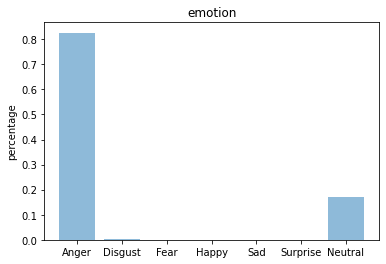

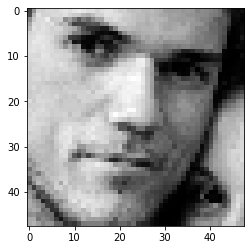

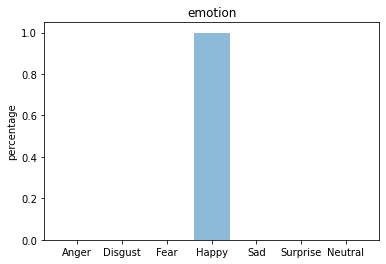

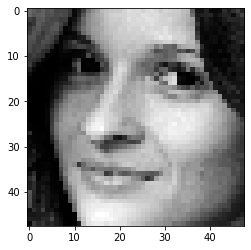

In [98]:
# 얼굴들의 감정 확인
for (top, right, bottom, left) in face_locations:
    crop = img[top:bottom, left:right]
    crop = cv2.resize(crop, (48, 48))
 
    x = image.img_to_array(crop)
    x = np.expand_dims(x, axis = 0)
 
    x /= 255
 
    custom = model.predict(x)
    emotion_analysis(custom[0])
 
    x = np.array(x, 'float32')
    x = x.reshape([48, 48])
 
    plt.gray()
    plt.imshow(x)
    plt.show()
    

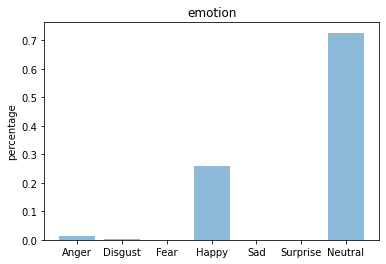

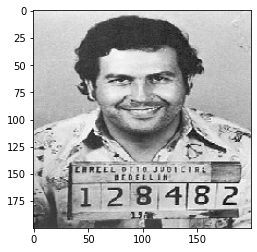

In [79]:
# 여기는 얼굴인식 하지 않고 얼굴 사진으로만 테스트
img = image.load_img("./data/test2.jpg", color_mode="grayscale", target_size=(48, 48))
show_img=image.load_img('./data/test2.jpg', target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
 
x /= 255
 
custom = model.predict(x)
emotion_analysis(custom[0])
 
x = np.array(x, 'float32')
x = x.reshape([48, 48])
 
plt.gray()
plt.imshow(show_img)
plt.show()